<a href="https://colab.research.google.com/github/Nuthan03/Dog_vision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#End-to-end Multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub

## 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [ ]:
#!unzip "/content/drive/MyDrive/Dog-vision/dog-breed-identification (1).zip" -d "/content/drive/MyDrive/Dog-vision/"

### Get our wokspace ready

In [ ]:
# Import TensorFlow into colab
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.14.0


In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF hub version", hub.__version__)

# Check for GPU availablity
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.14.0
TF hub version 0.15.0
GPU available


## Getting our data ready

With all machine learning models, our data has to be in numerical format. So we are going to do that first

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog-vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: >

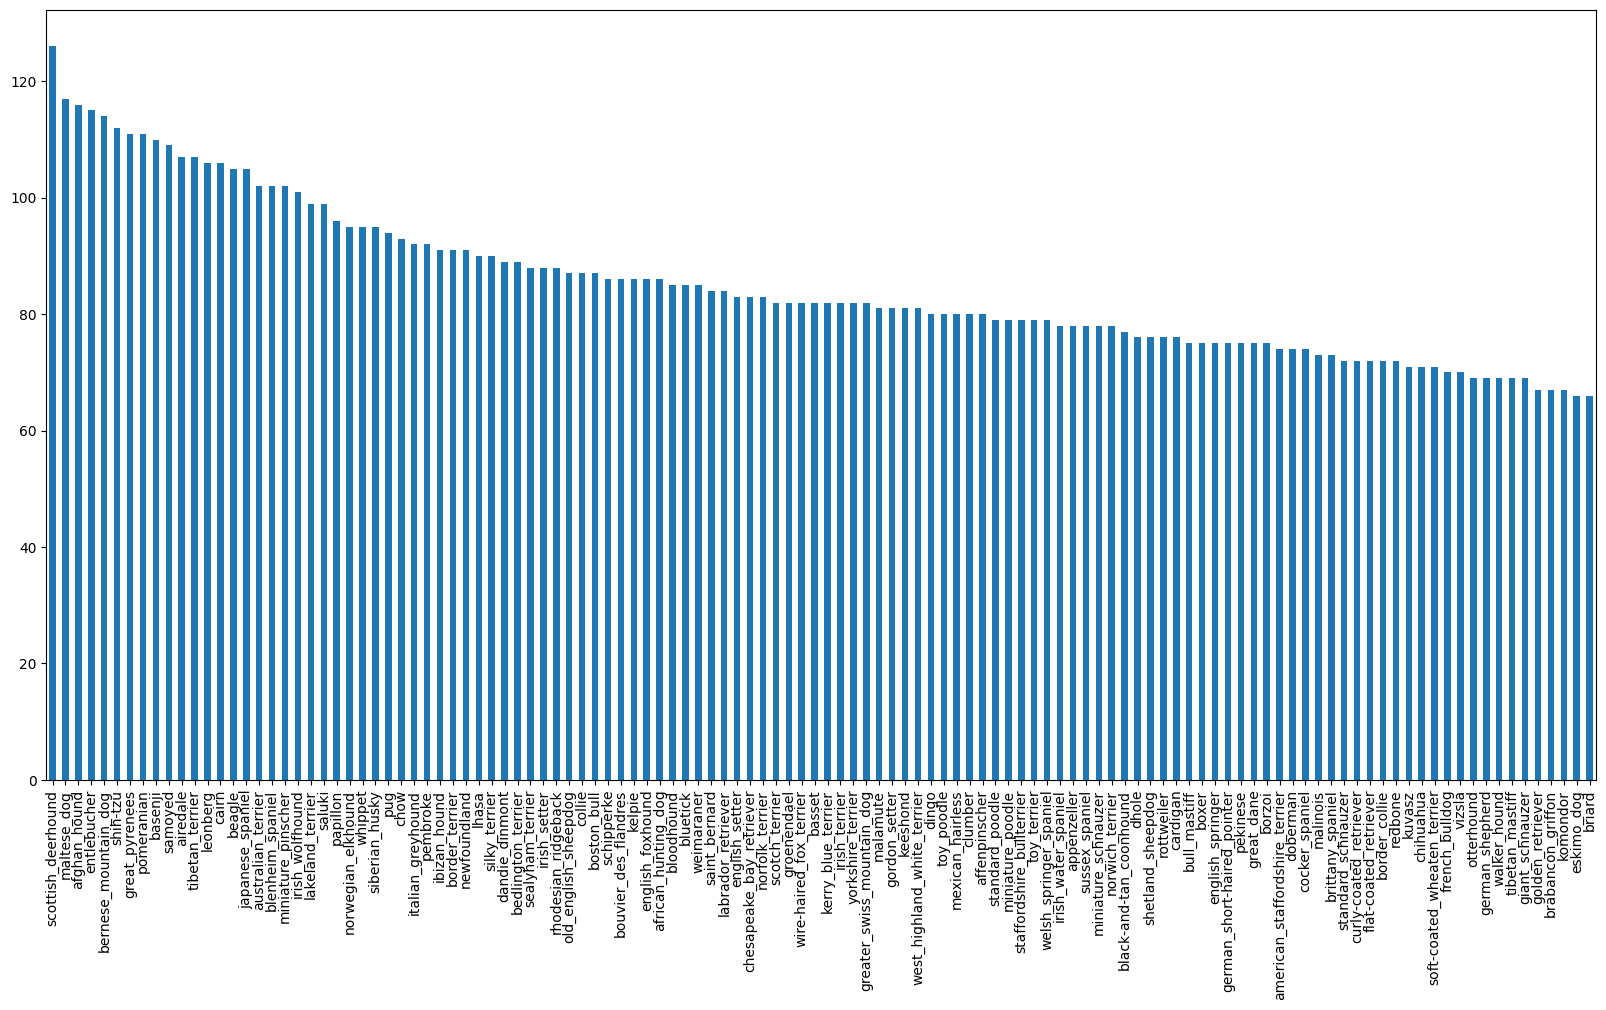

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

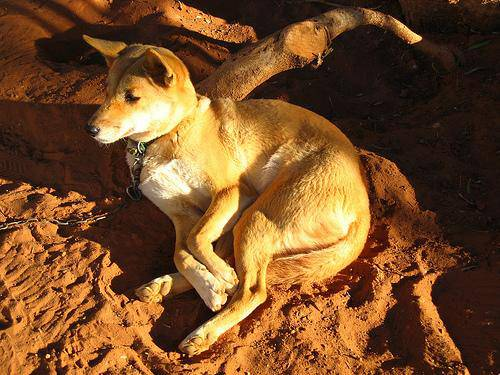

In [ ]:
# Let's view an image
from IPython.display import display, Image
Image("drive/MyDrive/Dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.



In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/Dog-vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
import os
os.listdir("drive/MyDrive/Dog-vision/train/")[:10]

['e3a8e45ac0004fb87d2ac40bad70114e.jpg',
 'dec0bb81afcfc4c35c7c6790975e5633.jpg',
 'e5470144eceb4e454681874ffe3e7e78.jpg',
 'e07277bc6a6a0da06598b3ad43a011b2.jpg',
 'e346c77b51b03999cbf7d89ae776e696.jpg',
 'e76a6bb8fdb21c7fcbb4f9f06bbda574.jpg',
 'e79a5176fe0322a36d09f057d64aec54.jpg',
 'e949de04a40965ca11bf4bc387cbcaf7.jpg',
 'e681969d4b5b730e9c93ce5e9d9ec9ff.jpg',
 'e3f184140f68b3502dfb048607556438.jpg']

In [ ]:
# Check wh      ether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog-vision/train/")) == len(filenames):
  print("Filenames match with the actual amount of files")
else:
  print("Filenames do not match with the actual files")


Filenames match with the actual amount of files


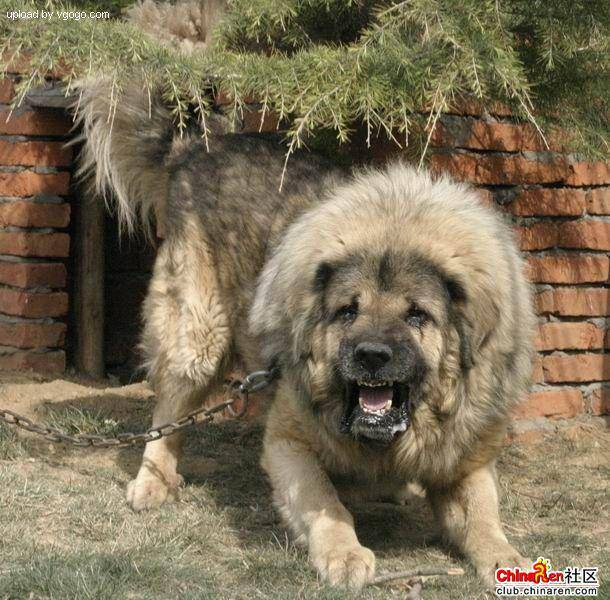

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we have our training image filepath in a list, let's prepare our labels

In [ ]:
import numpy as np
labels= labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("They dont match")

Number of labels matches number of filenames


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a booleans
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0] )) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
filenames[:10]

['drive/MyDrive/Dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

Creating our own validation set

In [ ]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

## We are going to start off experimenting with ~100 images and increase as needed

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Preprocessing Images (Turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images).

You might be wondering why (224, 224), which is (heigh, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is (224, 224, 3).

What? Where's the 3 from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.

In [ ]:
# Convert an image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
# Turning image into a tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
# Define image sizes
IMG_SIZE =224

#Create a function for preprocessing images
def process_image(image_path):
  """
  Takes a image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  #Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Turning our data into batches
What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of `process_image` function at the same time.


In [ ]:
# Create a simple function to return a tuple(image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have a way to turn our data into tupples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data `(X, y)` into batches

In [ ]:
from tensorflow.python.ops.batch_ops import batch
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably dont have labels
  if test_data:
    print("Creating test data ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we dont need to shuffle it
  elif valid_data:
    print("Creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepath
                                               tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creatign training data batches....")
    # Turn filepatchs and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create trainging and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creatign training data batches....
Creating validation data batches....


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
our data is now in batches, however these can be a little hard to understand/comprehend, let's visualize the data

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Display a plot of 25 iamges and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create sublpots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image ;abel as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines oof
    plt.axis("off")





In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

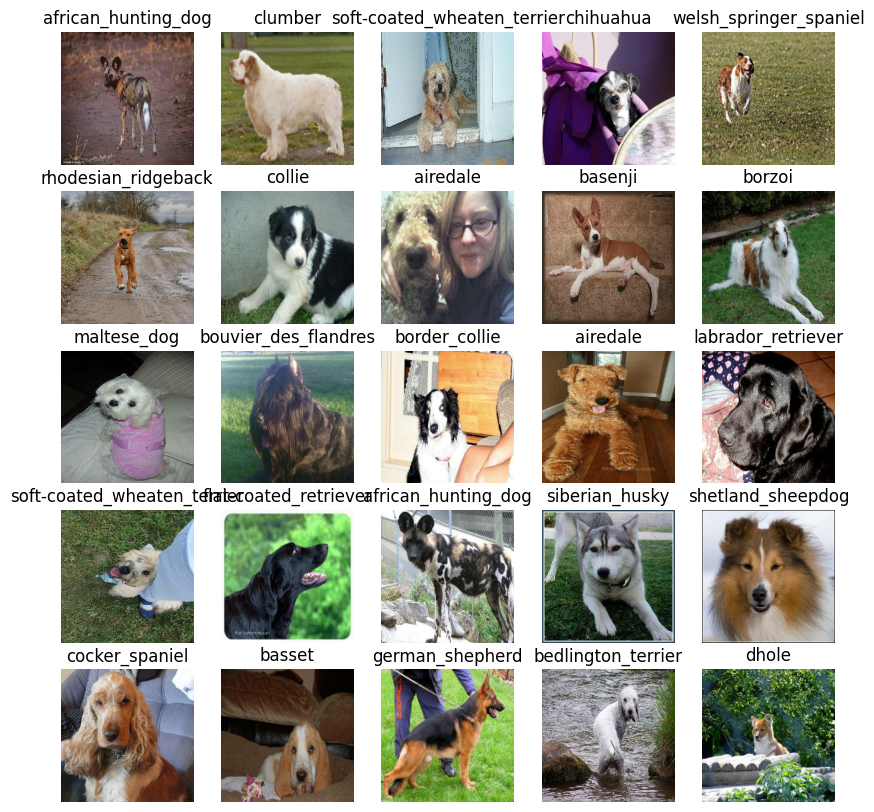

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

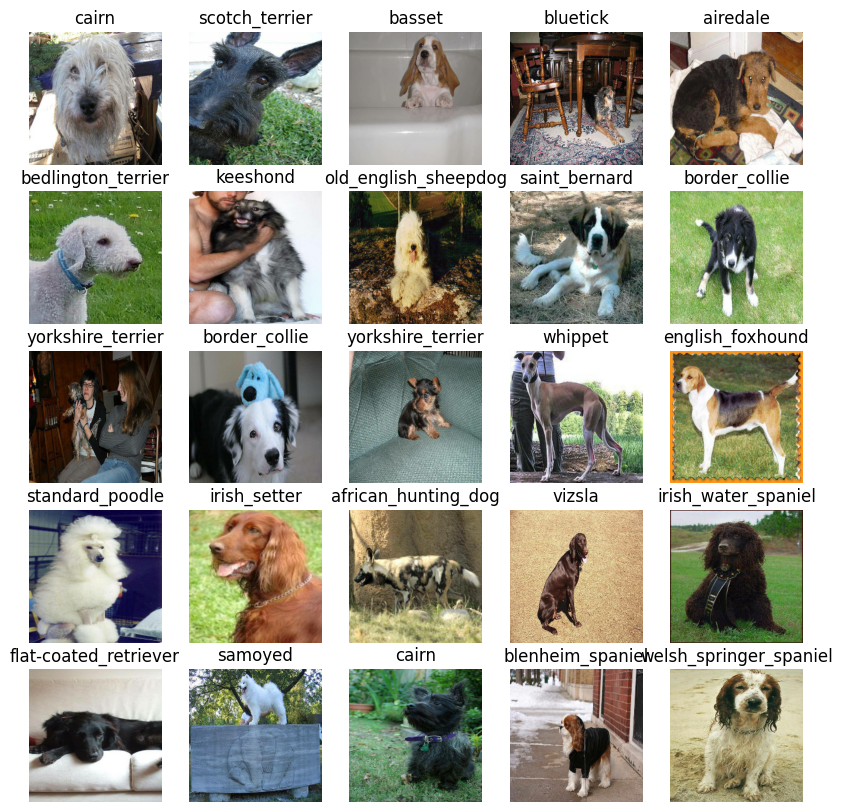

In [ ]:
# Let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often referred to as **transfer learning**.

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

#### How do we choose a model?

Since we know our problem is image classification (classifying different dog breeds), we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent).

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.


In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to [use the Keras API](https://www.tensorflow.org/guide/keras/overview).

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

We'll take a look at the code first, then dicuss each part.

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:",MODEL_URL)

  # Setup the model layers
  model= tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalFocalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Creating callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

#### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog-vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."



In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

### Training a model (on a subset of data)
Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

Along with this, let's quickly check if we're still using a GPU.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we are still runnning on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function which trains a model
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session evertime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 184s 7s/step - loss: 1.0998 - accuracy: 0.1163 - val_loss: 0.7558 - val_accuracy: 0.2600
Epoch 2/100
25/25 [==============================] - 3s 104ms/step - loss: 0.2993 - accuracy: 0.6737 - val_loss: 0.4160 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 3s 103ms/step - loss: 0.0552 - accuracy: 0.9413 - val_loss: 0.3180 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 3s 105ms/step - loss: 0.0128 - accuracy: 0.9950 - val_loss: 0.2986 - val_accuracy: 0.5950
Epoch 5/100
25/25 [==============================] - 3s 106ms/step - loss: 0.0063 - accuracy: 0.9962 - val_loss: 0.2917 - val_accuracy: 0.5900
Epoch 6/100
25/25 [==============================] - 4s 170ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2869 - val_accuracy: 0.6050
Epoch 7/100
25/25 [==============================]

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ vision/logs

<IPython.core.display.Javascript object>

### Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose= 1)
predictions

7/7 [==============================] - 3s 79ms/step


array([[2.7398863e-03, 1.5807223e-04, 4.6514529e-03, ..., 2.8392824e-04,
        6.1732062e-05, 5.7927151e-03],
       [1.1208794e-03, 8.4619252e-03, 6.6680671e-03, ..., 1.1853046e-03,
        5.7909833e-03, 2.0283335e-04],
       [1.3974984e-04, 4.7432186e-04, 1.0606209e-04, ..., 3.9788098e-03,
        1.3819036e-04, 1.4366186e-03],
       ...,
       [2.4309401e-04, 2.7509601e-04, 8.9033623e-04, ..., 4.0632547e-04,
        2.2483047e-03, 1.0295516e-03],
       [1.2035910e-02, 2.6731356e-04, 3.2091045e-04, ..., 4.1103479e-04,
        3.7930653e-04, 8.9871371e-03],
       [8.2004513e-04, 1.2387296e-03, 1.5693379e-03, ..., 1.1921332e-03,
        1.4762401e-03, 3.0907959e-04]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val)

200

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[0])}")
print(f"Max index: {np.argmax(predictions[0])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}")

[2.73988629e-03 1.58072231e-04 4.65145288e-03 5.06569166e-04
 2.85578251e-04 2.04344722e-03 1.74149629e-02 2.36819289e-03
 6.16458186e-04 3.59433063e-04 2.45688949e-04 8.87739181e-04
 3.63619300e-04 1.23768696e-03 4.03530989e-03 7.68507191e-04
 5.35553670e-04 1.67784438e-01 3.27323214e-05 5.49173914e-04
 1.48704425e-02 1.86100282e-04 6.01335523e-05 7.41743064e-03
 1.72943241e-04 1.99640301e-04 1.06013402e-01 5.25433825e-05
 1.84042798e-03 1.22507766e-03 2.22142728e-04 1.18571920e-02
 1.37918943e-03 7.09821907e-05 5.64920483e-04 4.25581150e-02
 1.79351235e-04 4.65688863e-05 1.42001227e-04 2.94985622e-03
 4.79217432e-03 8.44496171e-05 2.26458986e-04 1.70057372e-03
 1.37086710e-04 4.12216614e-04 3.13854602e-04 1.21149984e-04
 2.47361953e-03 2.43337173e-03 4.06199251e-04 1.83694094e-04
 9.36051365e-05 1.48782937e-03 1.83703989e-04 3.42212967e-04
 2.16402972e-04 5.75427245e-03 5.54223254e-04 2.48146765e-02
 1.30326906e-03 4.27015621e-04 1.21715234e-03 5.92562792e-05
 8.81014334e-04 3.886481

In [ ]:
# Turn prediction probabilities into their respective label (for clients)
def get_pred_label(predictions_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(predictions_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label= get_pred_label(predictions[0])
pred_label

'border_terrier'

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [ ]:
def plot_pred(predictions_probabilities, labels, images, n=1):
  """
  View the predictions,ground truth and image for sample n
  """
  pred_prob, true_label, image = predictions_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot iamge & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)


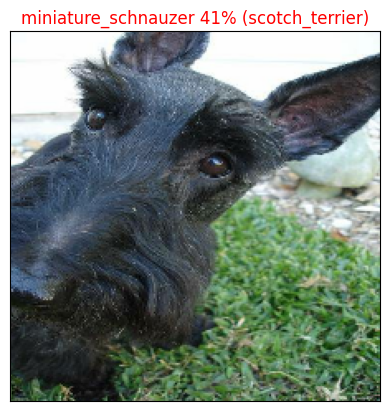

In [ ]:
plot_pred(predictions_probabilities=predictions,
          labels=val_labels,
          images=val_images
          )

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using get_pred_label().
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(predictions_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = predictions_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top prediction confidence
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Set plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

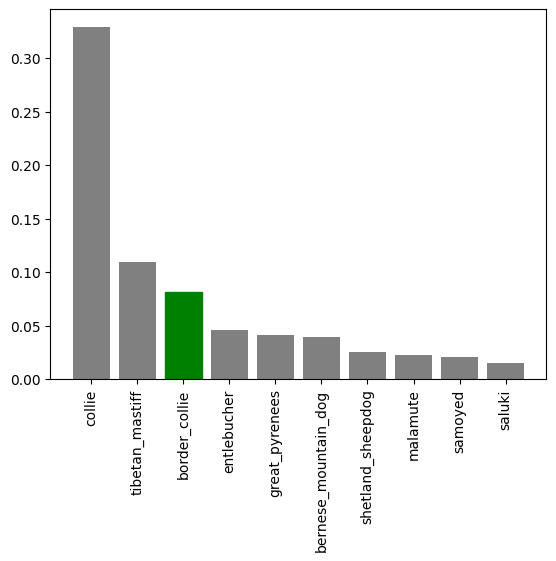

In [ ]:
plot_pred_conf(predictions_probabilities=predictions,
               labels=val_labels,
               n=9)

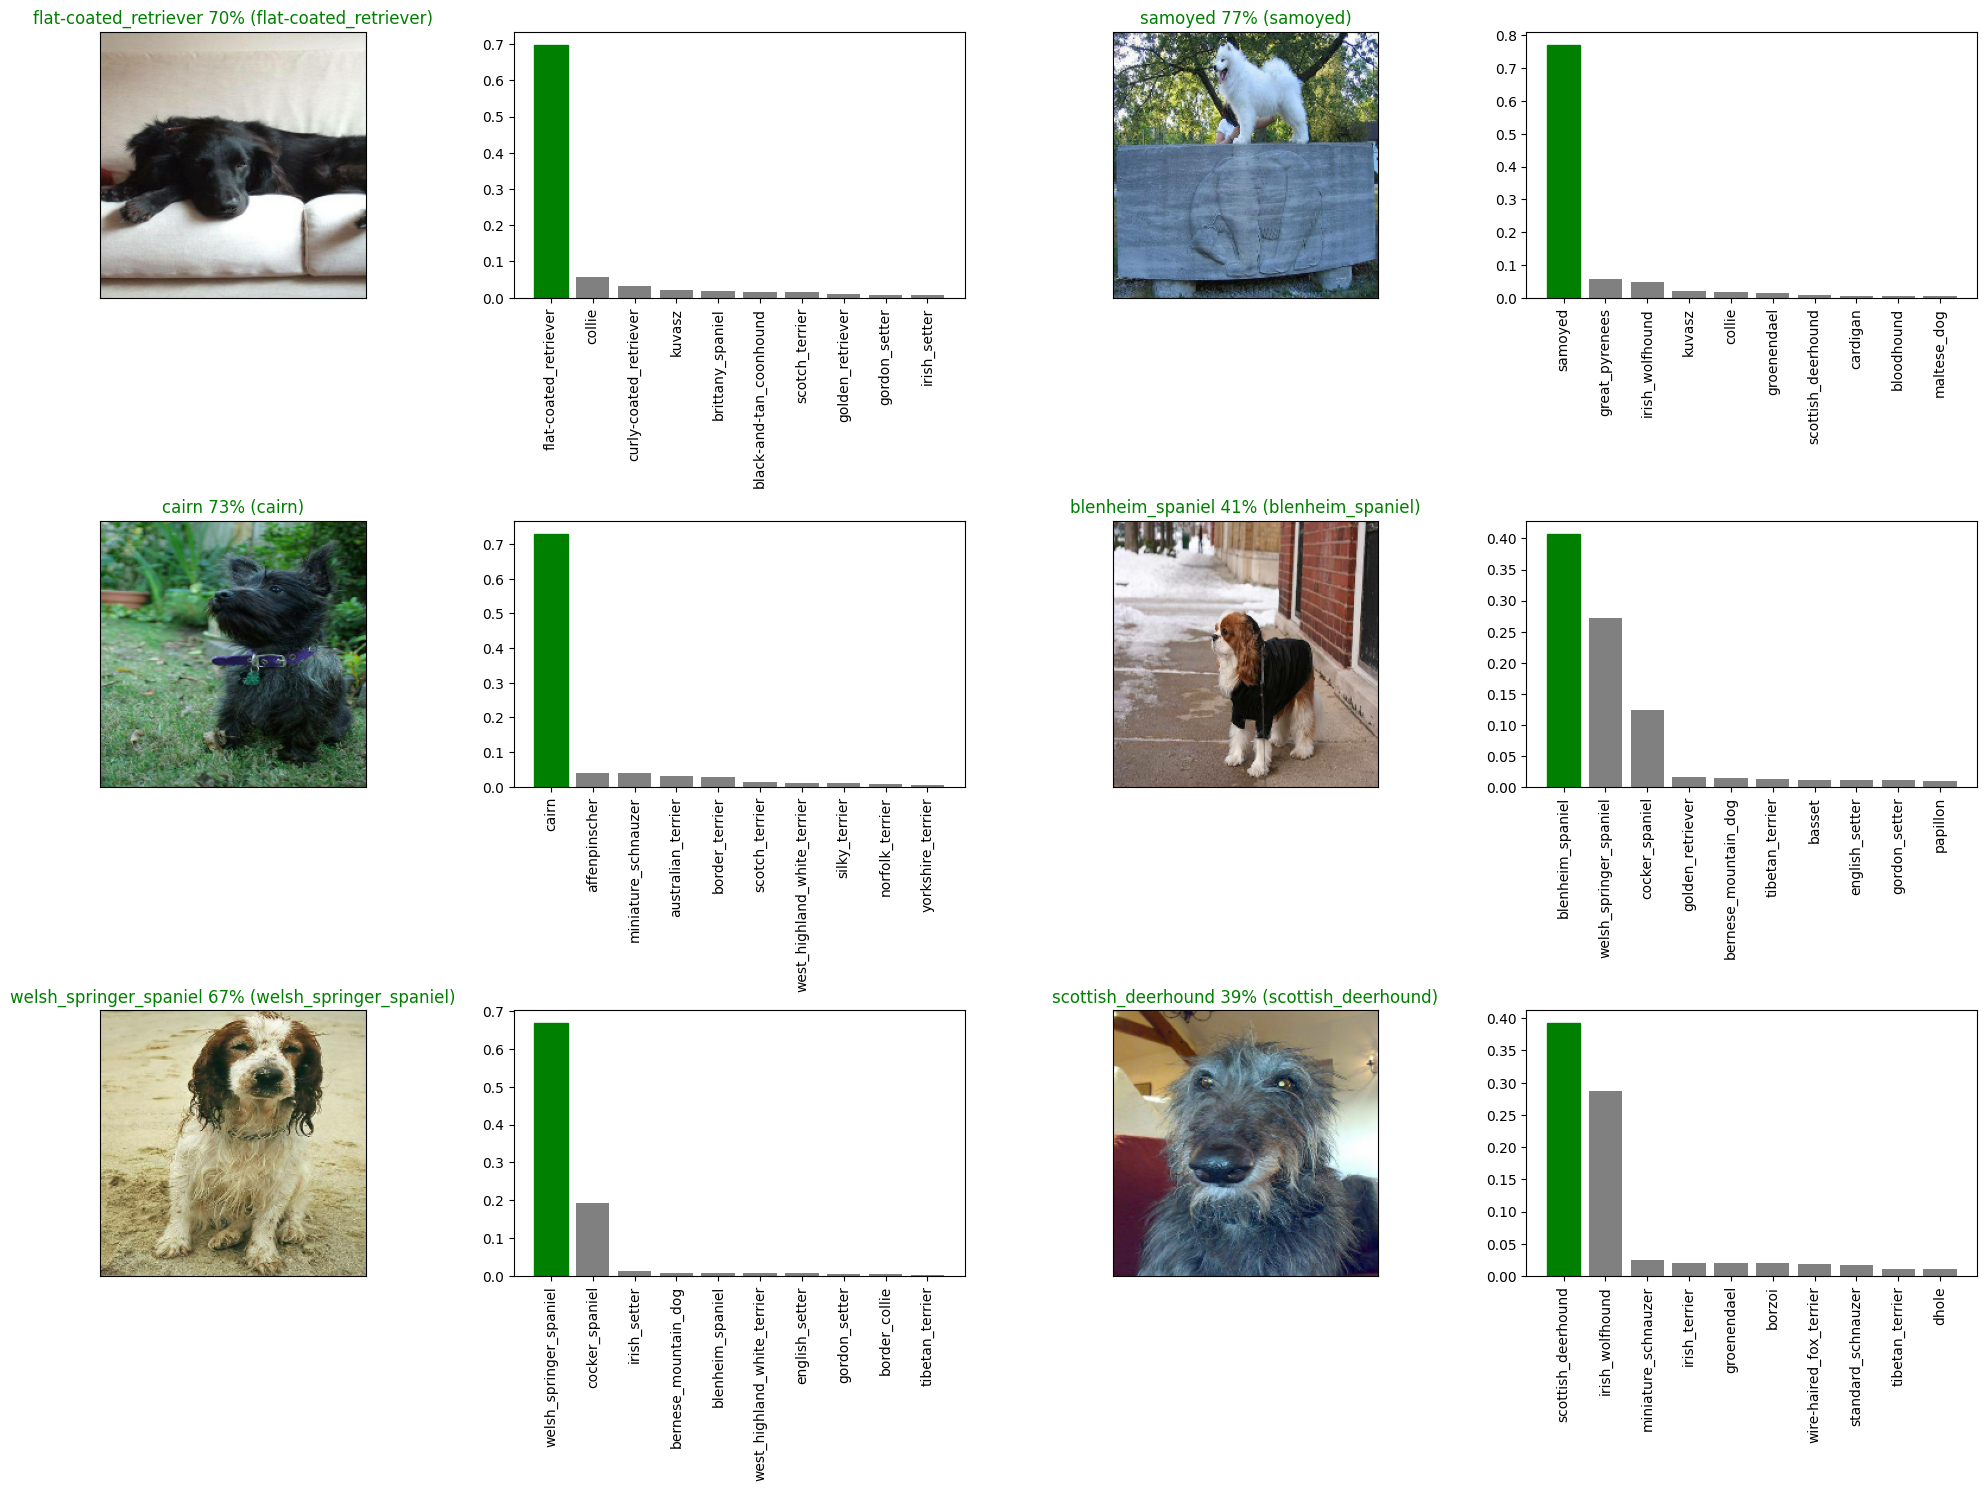

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predictions_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(predictions_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [ ]:
# Create a function a save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string)
  """
  # Create a model directory pathname with current time.
  modeldir = os.path.join("drive/MyDrive/Dog-vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" #save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog-vision/models/20231101-12271698841669-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Dog-vision/models/20231101-12271698841669-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('drive/MyDrive/Dog-vision/models/20231029-06221698560535-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog-vision/models/20231029-06221698560535-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 98ms/step - loss: 0.2750 - accuracy: 0.6200


[0.2749657928943634, 0.6200000047683716]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 2s 109ms/step - loss: 0.2862 - accuracy: 0.6050


[0.2862130403518677, 0.6050000190734863]

## Training a big dog model

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
full_data = create_data_batches(X, y)

Creatign training data batches....


In [ ]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)


In [ ]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 34s 95ms/step - loss: 0.2681 - accuracy: 0.6639
Epoch 2/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0556 - accuracy: 0.8751
Epoch 3/100
320/320 [==============================] - 30s 92ms/step - loss: 0.0259 - accuracy: 0.9296
Epoch 4/100
320/320 [==============================] - 29s 92ms/step - loss: 0.0123 - accuracy: 0.9652
Epoch 5/100
320/320 [==============================] - 29s 92ms/step - loss: 0.0065 - accuracy: 0.9820
Epoch 6/100
320/320 [==============================] - 31s 96ms/step - loss: 0.0043 - accuracy: 0.9882
Epoch 7/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0032 - accuracy: 0.9935
Epoch 8/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0022 - accuracy: 0.9962
Epoch 9/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0021 - accuracy: 0.9967
Epoch 10/100
320/320 [==============================] - 30s 92ms/step - l

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog-vision/models/20231101-12351698842106-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog-vision/models/20231101-12351698842106-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
loaded_full_model = load_model('drive/MyDrive/Dog-vision/models/20231029-06491698562184-full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog-vision/models/20231029-06491698562184-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

In [ ]:
# Laod test image filenames
test_path = "drive/MyDrive/Dog-vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog-vision/test/e2b808864a5253fd356a9032915447a1.jpg',
 'drive/MyDrive/Dog-vision/test/e721c3eec5951861bf3ed7f40ef8b091.jpg',
 'drive/MyDrive/Dog-vision/test/e27567e188000db387977cdb9bbdcf82.jpg',
 'drive/MyDrive/Dog-vision/test/e52a4321a8cb0dd3bcc8f4a68b75eee7.jpg',
 'drive/MyDrive/Dog-vision/test/e48e4d9137c69e69f54f85907c061172.jpg',
 'drive/MyDrive/Dog-vision/test/debfa5cad80e35c510dff6ca29b94ca3.jpg',
 'drive/MyDrive/Dog-vision/test/e527455253416f809a73886b6003020d.jpg',
 'drive/MyDrive/Dog-vision/test/e5f2204119380ce1a17fd09435c5012a.jpg',
 'drive/MyDrive/Dog-vision/test/e4b7ff61849485992246c0f2ab7e8804.jpg',
 'drive/MyDrive/Dog-vision/test/e292584f17fa7cea7f95bdadecde0ebb.jpg']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data ...


In [ ]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Making prediction on test data batch using the loaded full model

test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [ ]:
# Save predictions to csv file
np.savetxt("drive/MyDrive/Dog-vision/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
# Load predictions from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog-vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

## Preparing test dataset predictions for Kaggle

In [ ]:
#["id"] + list(unique_breeds)

In [ ]:
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e2b808864a5253fd356a9032915447a1           NaN          NaN   
1  e721c3eec5951861bf3ed7f40ef8b091           NaN          NaN   
2  e27567e188000db387977cdb9bbdcf82           NaN          NaN   
3  e52a4321a8cb0dd3bcc8f4a68b75eee7           NaN          NaN   
4  e48e4d9137c69e69f54f85907c061172           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e2b808864a5253fd356a9032915447a1   2.122332e-06  1.541105e-04   
1  e721c3eec5951861bf3ed7f40ef8b091   3.958627e-05  2.745315e-04   
2  e27567e188000db387977cdb9bbdcf82   4.953569e-09  1.487615e-09   
3  e52a4321a8cb0dd3bcc8f4a68b75eee7   3.164523e-05  1.489214e-03   
4  e48e4d9137c69e69f54f85907c061172   1.313818e-05  3.581887e-03   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         8.161430e-06  1.505909e-06                    3.885480e-07   
1         5.327631e-07  3.124909e-07                    3.928583e-06   
2         1.929399e-07  9.404695e-11                    3.406342e-08   
3         6.821996e-06  8.694586e-07                    1.167381e-06   
4         5.225222e-01  3.680027e-04                    9.524491e-07   

    appenzeller  australian_terrier   basenji        basset  ...  \
0  6.999984e-03        2.780917e-05  0.002308  1.015223e-05  ...   
1  6.416525e-06        1.102444e-06  0.000010  1.534850e-06  ...   
2  1.864396e-07        2.694711e-07  0.000222  2.738122e-08  ...   
3  7.958050e-06        2.074706e-05  0.000001  5.481006e-06  ...   
4  1.671651e-06        8.198103e-04  0.000358  4.086058e-05  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  2.130325e-05  4.026037e-05  7.615001e-05  4.016113e-05  2.787377e-05   
1  8.060999e-06  2.485649e-07  1.235961e-05  9.191049e-05  2.762526e-04   
2  8.066072e-09  1.137501e-06  2.713514e-09  2.186237e-09  2.442522e-09   
3  1.641635e-06  8.107461e-07  6.160460e-07  1.676569e-05  5.922143e-06   
4  2.962766e-04  8.392107e-04  4.847851e-05  2.800518e-05  1.029384e-04   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            6.186198e-06                 2.678592e-06  2.818333e-03   
1            6.054946e-07                 3.896632e-06  1.607252e-07   
2            8.133806e-08                 1.110388e-08  1.032318e-08   
3            3.389640e-08                 1.577963e-07  2.179104e-06   
4            1.660321e-05                 3.828708e-04  6.669686e-05   

   wire-haired_fox_terrier  yorkshire_terrier  
0             2.052175e-05       2.654588e-06  
1             8.052643e-07       1.136444e-06  
2             1.266611e-07       3.614974e-09  
3             1.700610e-06       1.092278e-06  
4             3.653354e-06       1.009549e-04  

[5 rows x 121 columns]

In [ ]:
preds_df.to_csv("drive/MyDrive/Dog-vision/full_model_predictions_submission_1_mobilenetV2.csv", index=False)

## Making predictions on custom images

In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog-vision/Dog/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if not fname.endswith('.ipynb_checkpoints')]

In [ ]:
custom_image_paths

['drive/MyDrive/Dog-vision/Dog/dog-photo-6.jpeg',
 'drive/MyDrive/Dog-vision/Dog/dog-photo-5.jpeg',
 'drive/MyDrive/Dog-vision/Dog/dog-photo-3.jpeg',
 'drive/MyDrive/Dog-vision/Dog/dog-photo-2.jpeg',
 'drive/MyDrive/Dog-vision/Dog/dog-photo-1.jpeg']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data ...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 3s 3s/step


In [ ]:
custom_preds.shape

(5, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['italian_greyhound',
 'walker_hound',
 'labrador_retriever',
 'lakeland_terrier',
 'golden_retriever']

In [ ]:
# Get custom images
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

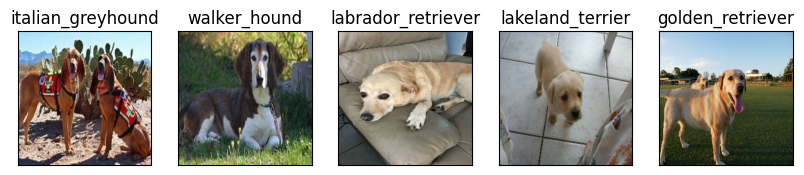

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)